In [30]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Regression Model for Flight Delays

Use [this dataset of airline arrival information](http://stat-computing.org/dataexpo/2009/the-data.html) to predict how late flights will be. A flight only counts as late if it is more than 30 minutes late.

## Data Cleaning/Inspection

Files were downloaded one by one, and then decompressed from the bz2 format to csv with the following Linux code:
**bunzip2 *bz2**

The individual csv files were then merged into one file:
**cat *.csv >merged.csv**

Using the following Linux code revealed that there are 123534991 rows in the merged data:
**wc -l merged.csv**

Since the purpose of the model is to predict how late a flight will be, a binary column for lateness will first be added to the dataset. Then late flights will be selected into a sample population to train the model.  

Considering the size of the dataset, it imported into an SQL Database through PostgreSQL. The csv files for 2001 and 2002 have non-UTF-8 encoded characters under the 'Tail Number' column. Considering the size of the database as a whole, these years will be excluded.   

**These columns will be cleaned so the Tail Numbers will still correlate to inidivudal flights without the extra characters. These csv files were cleaned through the process below, then separate csv files (with 'a' added at the end of the title) were imported into the SQL database: <-- fix or no?**

**The following SQL code was used to create a database of only late flight for model training:**

ALTER TABLE airline_arrivals 
 ADD COLUMN time_late BIGINT,
 ADD COLUMN late BIGINT;
 
To populate the time_late column:

UPDATE airline_arrivals SET "time_late" = "ArrTime" - "CRSArrTime"

To populate the late column:
UPDATE airline_arrivals
SET "late" = 1
WHERE "time_late" > 30

UPDATE airline_arrivals
SET "late" = 0
WHERE "time_late" <= 30

A new table called late_flights was created:
CREATE TABLE late_flights 
AS (SELECT * FROM airline_arrivals WHERE "late"=1);

And finally, a random selection of 100,000 flights will be selected from the late_flights table:
CREATE TABLE rand_late_flights_1 
AS (SELECT * FROM late_flights
	WHERE "late" = 1
	ORDER BY random()
	LIMIT 100000)

The resulting database has 18333751 rows, meaning of all the domestic flights in the United States from 1987-2008 (excluding 2001 and 2002), about 15% were late. 

In [31]:
# connect to sql database
import psycopg2 as pg
import pandas.io.sql as psql
connection = pg.connect("dbname=postgres port=5433 user=postgres password='Aurora17'")
# read data to pandas
df = pd.read_sql_query("SELECT * FROM rand_late_flights_1", connection)
df.head()

,Year,Month,DayOfMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,late,time_late
0,1997,9,24,3,657.0,700,913.0,855,CO,1907,...,0,None,0,NaN,NaN,NaN,NaN,NaN,1,58
1,2005,10,7,5,1907.0,1830,2128.0,2040,FL,994,...,0,,0,0.0,0.0,11.0,0.0,37.0,1,88
2,1999,4,23,5,1830.0,1630,2214.0,1947,AA,494,...,0,None,0,NaN,NaN,NaN,NaN,NaN,1,267
3,2006,11,17,5,2057.0,2026,2213.0,2152,UA,593,...,0,,0,11.0,0.0,0.0,0.0,10.0,1,61
4,1994,4,21,4,1705.0,1705,1905.0,1853,HP,1260,...,0,None,0,NaN,NaN,NaN,NaN,NaN,1,52


The import looks good, now we will drop rows with null values to allow for better modelling. There is so much data the results should not be affected.

In [32]:
# drop null values
df=df.dropna()

There are some categorical features in the data, what data types are they?

In [33]:
# see the types of data in each column
df.dtypes

Year                   int64
Month                  int64
DayOfMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum               object
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin                object
Dest                  object
Distance             float64
TaxiIn               float64
TaxiOut              float64
Cancelled              int64
CancellationCode      object
Diverted               int64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
late                   int64
time_late              int64
dtype: object

There are object-type data in the set, meaning it will need to be categorized in order to model. What do the object columns look like?

In [34]:
# recategorize the object columns as category
df = pd.concat([
        df.select_dtypes([], ['object']),
        df.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
        ], axis=1).reindex(df.columns, axis=1)
# create categorical values
objs=df[['UniqueCarrier', 'TailNum', 'Origin', 'Dest', 'CancellationCode']]
objs = objs.apply(lambda x: x.cat.codes)
# drop string values and add categorical values
df=df.drop(['UniqueCarrier', 'TailNum', 'Origin', 'Dest', 'CancellationCode'],1)
df=pd.concat([df, objs], 1)

The categorical values and string values are mapped in the function and can be found by calling the function. Example for finding the first value in the 'Dest' column:
**df.Dest.cat.categories[0]**

Since a flight is considered late if it arrives 30 minutes or more after the scheduled arrival time, a column will be added to show the difference between scheduled and actual arrival times. Then a binary column will be added, showing a 1 for 30 minutes or more, and 0 for less than 30 minutes.

Next the features will be run into a correlation matrix to see how they interact with each other.

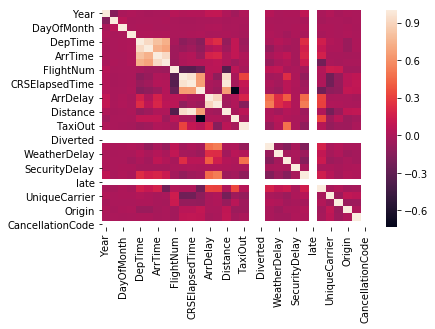

In [35]:
# create correlation matrix
corr=df.corr()

# plot matrix
sns.heatmap(corr)

Cancelled, late and diverted have extremely high correlation. Since cancelled and diverted flight are always late that information will be captured in the late column, and cancelled and diverted will be dropped. There also appears to be significant correlation in the beginning of the dataset, so those features will be focused on.

In [36]:
df=df.drop(['Cancelled', 'Diverted'], 1)

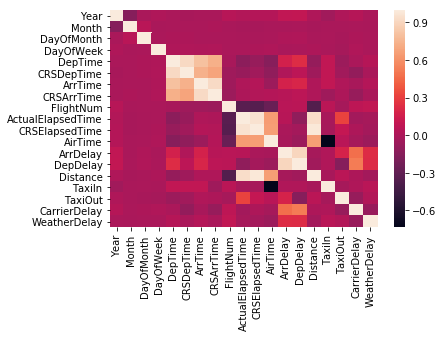

In [37]:
# slice the first half of the data and create new correlation matrix
ff=df.iloc[:, :19]
corr2=ff.corr()
sns.heatmap(corr2)

DepTime, CRS DepTime, ArrTime and CRSArrTime are all highly correlated as they all relate to flight time. These features will be averaged into one in order to reduce multicollinearity. Also, the same for ArrDelay and DepDelay. There also appears to be correlation between Distance and the Elapsed Time features, but as this has real world implications (flights over greater distance have longer air time), nothing will be done to fix the relationship between these variables. Finally, ActualElapsedTime, CRSElapsedTime and AirTime all show almost the same information, so only AirTime will be kept. 

In [38]:
# aggregate all time related features
mean_time = df[['DepTime','CRSDepTime','ArrTime', 'CRSArrTime']].mean(axis=0)
stds_time = df[['DepTime','CRSDepTime','ArrTime', 'CRSArrTime']].std(axis=0)
df['time_vars'] = ((df[['DepTime','CRSDepTime','ArrTime', 'CRSArrTime']] - mean_time) / stds_time).mean(axis=1)
df=df.drop(['DepTime','CRSDepTime','ArrTime', 'CRSArrTime'], 1)
# aggregate all delay related features
mean_delay = df[['ArrDelay', 'DepDelay']].mean(axis=0)
stds_delay = df[['ArrDelay', 'DepDelay']].std(axis=0)
df['delay_vars'] = ((df[['ArrDelay', 'DepDelay']] - mean_delay) / stds_delay).mean(axis=1)
df=df.drop(['ArrDelay', 'DepDelay'], 1)
# drop actualelapsedtime and crselapsedtime
df=df.drop(['ActualElapsedTime', 'CRSElapsedTime'], 1)

The correlation matrix will be rerun to see how the feature engineering affected the entirety of the data.

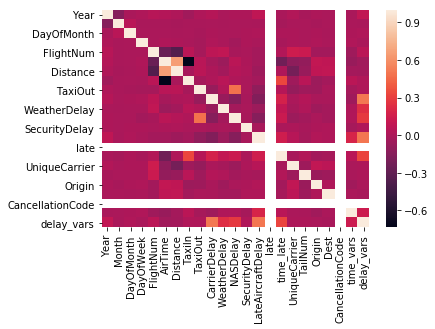

In [39]:
# rerun correlation matrix
corr=df.corr()
sns.heatmap(corr)

Now the data looks to have much less of a chance of multicollinearity. How does this final dataset look? 

In [40]:
# find information about dataframe for the model
df.describe()

,Year,Month,DayOfMonth,DayOfWeek,FlightNum,AirTime,Distance,TaxiIn,TaxiOut,CarrierDelay,...,LateAircraftDelay,late,time_late,UniqueCarrier,TailNum,Origin,Dest,CancellationCode,time_vars,delay_vars
count,35726.000000,35726.000000,35726.000000,35726.000000,35726.000000,35726.000000,35726.000000,35726.000000,35726.000000,35726.000000,...,35726.000000,35726.0,35726.000000,35726.000000,35726.000000,35726.000000,35726.000000,35726.0,3.572600e+04,3.572600e+04
mean,2005.759951,6.696999,15.961037,3.918379,2213.129038,104.079550,732.880591,11.805408,23.073420,15.262078,...,19.210295,1.0,114.468734,12.436293,3371.480630,139.150143,145.768768,0.0,-1.390343e-16,-2.375143e-17
std,1.556272,3.478001,8.715691,1.978739,1985.668990,106.001433,567.180005,77.050130,19.441543,35.947738,...,35.112151,0.0,184.524929,6.764714,1858.131372,77.673879,79.743125,0.0,9.212346e-01,9.756442e-01
min,2003.000000,1.000000,1.000000,1.000000,1.000000,-1415.000000,28.000000,0.000000,0.000000,0.000000,...,0.000000,1.0,31.000000,0.000000,0.000000,0.000000,0.000000,0.0,-2.919602e+00,-1.664097e+00
25%,2004.000000,4.000000,8.000000,2.000000,617.000000,57.000000,325.000000,4.000000,12.000000,0.000000,...,0.000000,1.0,56.000000,7.000000,1804.000000,77.000000,78.000000,0.0,-7.280775e-01,-6.344161e-01
50%,2006.000000,7.000000,16.000000,4.000000,1518.500000,89.000000,583.000000,6.000000,17.000000,0.000000,...,0.000000,1.0,79.000000,14.000000,3423.000000,146.000000,156.000000,0.0,1.104903e-01,-2.585178e-01
75%,2007.000000,10.000000,23.000000,5.000000,3696.000000,137.000000,951.000000,9.000000,27.000000,16.000000,...,28.000000,1.0,114.000000,19.000000,4994.000000,204.000000,209.000000,0.0,7.669758e-01,3.127658e-01
max,2008.000000,12.000000,31.000000,7.000000,9579.000000,641.000000,4962.000000,1458.000000,345.000000,737.000000,...,494.000000,1.0,2606.000000,22.000000,6375.000000,289.000000,299.000000,0.0,1.804022e+00,1.398144e+01


The data looks fit for modelling. Linear Regression will be used as there is a linear relationship between time and distance, and linear regression will optimally show what else can make a flight late from the additional features. 

## Linear Regression to Predict How Late a Flight Is

In [41]:
from sklearn import linear_model
import statsmodels.api as sm
# Instantiate and fit our model.
Y = df['time_late']
X = df.drop(['late', 'time_late'], 1).astype(float)
# Fit and summarize OLS model
mod = sm.OLS(Y, X, hasconst=False).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              time_late   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     1435.
Date:                Fri, 18 Jan 2019   Prob (F-statistic):               0.00
Time:                        11:21:52   Log-Likelihood:            -2.3238e+05
No. Observations:               35726   AIC:                         4.648e+05
Df Residuals:                   35706   BIC:                         4.650e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Year                 -0.0234      0.004     -6.322      0.000      -0.031      -0.016
Month                -0.7211      0.246     -2.926      0.003      -1.204      -0.238
DayOfMonth            0.0412      0.098      0.418      0.676      -0.152       0.234
DayOfWeek            -0.6450      0.433     -1.490      0.136      -1.494       0.204
FlightNum             0.0012      0.000      2.516      0.012       0.000       0.002
AirTime              -0.8316      0.044    -18.727      0.000      -0.919      -0.745
Distance              0.1111      0.006     19.759      0.000       0.100       0.122
TaxiIn               -0.0596      0.046     -1.296      0.195      -0.150       0.030
TaxiOut              -1.1763      0.073    -16.208      0.000      -1.319      -1.034
CarrierDelay          3.7571      0.138     27.263      0.000       3.487       4.027
WeatherDelay          3.6806      0.144     25.589      0.000       3.399       3.963
NASDelay              3.5981      0.130     27.765      0.000       3.344       3.852
SecurityDelay         3.6117      0.373      9.679      0.000       2.880       4.343
LateAircraftDelay     3.7180      0.138     27.009      0.000       3.448       3.988
UniqueCarrier         0.1381      0.132      1.043      0.297      -0.121       0.398
TailNum               0.0004      0.000      0.825      0.409      -0.001       0.001
Origin               -0.0478      0.011     -4.269      0.000      -0.070      -0.026
Dest                 -0.0075      0.011     -0.694      0.488      -0.029       0.014
CancellationCode   8.569e-16   1.23e-16      6.995      0.000    6.17e-16     1.1e-15
time_vars             0.6586      0.958      0.687      0.492      -1.220       2.537
delay_vars         -127.3070      6.872    -18.526      0.000    -140.776    -113.838
==============================================================================
Omnibus:                    59227.329   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         39793871.537
Skew:                          11.369   Prob(JB):                         0.00
Kurtosis:                     164.913   Cond. No.                     2.37e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.53e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

The model is relatively accurate, with an r-squared value of about 45%. DayofMonth, DayofWeek, TaxiIn, UniqueCarrier, TailNum, Dest and time_vars all have p-values greater than 0.05, meaning they do not have much value to predicting tardiness. What else can we learn about the balance of data? 

In [13]:
# have to wrap sklearn baseestimators over statsmodels objects to run cross validation with statsmodel
import statsmodels.api as sm
from sklearn.base import BaseEstimator, RegressorMixin

class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

In [42]:
# run cross validation testing
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

X, Y = make_regression()

print(cross_val_score(SMWrapper(sm.OLS), X, Y, cv=10))

[0.68932281 0.60815037 0.92794104 0.87347464 0.93486212 0.92674652
 0.75801126 0.78241242 0.45525771 0.9428986 ]


The cross validation scores show the data is imbalanced, which could srise from a number of factors. What happens when we rerun the model on a new import of data from the SQL database?

## Test on Second Random Import

A second tale called rand_late_flight_2 was created:
CREATE TABLE rand_late_flights_2 
AS (SELECT * FROM late_flights
	WHERE "late" = 1
	ORDER BY random()
	LIMIT 100000)

In [43]:
# connect to sql database 
connection = pg.connect("dbname=postgres port=5433 user=postgres password='Aurora17'")
# read data to pandas
df_test = pd.read_sql_query("SELECT * FROM rand_late_flights_2", connection)
# create a dataframe from chunk
df_test.head()

,Year,Month,DayOfMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,late,time_late
0,1998,6,13,6,1619.0,1235,1837.0,1510,NW,480,...,0,None,0,NaN,NaN,NaN,NaN,NaN,1,327
1,1998,12,5,6,831.0,0,1107.0,0,AA,1007,...,0,None,0,NaN,NaN,NaN,NaN,NaN,1,1107
2,1989,4,30,7,1440.0,1440,1553.0,1518,DL,1091,...,0,None,0,NaN,NaN,NaN,NaN,NaN,1,35
3,2006,1,3,2,800.0,800,1110.0,1045,WN,759,...,0,,0,0.0,0.0,25.0,0.0,0.0,1,65
4,1991,1,21,1,1110.0,1042,1438.0,1342,CO,699,...,0,None,0,NaN,NaN,NaN,NaN,NaN,1,96


In [44]:
# repeat data cleaning procedures from first import
df_test= pd.concat([
        df_test.select_dtypes([], ['object']),
        df_test.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
        ], axis=1).reindex(df_test.columns, axis=1)
# create categorical values
objs_test=df_test[['UniqueCarrier', 'TailNum', 'Origin', 'Dest', 'CancellationCode']]
objs_test = objs_test.apply(lambda x: x.cat.codes)
# drop string values and add categorical values
df_test=df_test.drop(['UniqueCarrier', 'TailNum', 'Origin', 'Dest', 'CancellationCode'],1)
df_test=pd.concat([df_test, objs_test], 1)
df_test=df_test.dropna()
df_test=df_test.drop(['Cancelled', 'Diverted'], 1)
# aggregate all time related features
mean_time = df_test[['DepTime','CRSDepTime','ArrTime', 'CRSArrTime']].mean(axis=0)
stds_time = df_test[['DepTime','CRSDepTime','ArrTime', 'CRSArrTime']].std(axis=0)
df_test['time_vars'] = ((df_test[['DepTime','CRSDepTime','ArrTime', 'CRSArrTime']] - mean_time) / stds_time).mean(axis=1)
df_test=df_test.drop(['DepTime','CRSDepTime','ArrTime', 'CRSArrTime'], 1)
# aggregate all delay related features
mean_delay = df_test[['ArrDelay', 'DepDelay']].mean(axis=0)
stds_delay = df_test[['ArrDelay', 'DepDelay']].std(axis=0)
df_test['delay_vars'] = ((df_test[['ArrDelay', 'DepDelay']] - mean_delay) / stds_delay).mean(axis=1)
df_test=df_test.drop(['ArrDelay', 'DepDelay'], 1)
# drop actualelapsedtime and crselapsedtime
df_test=df_test.drop(['ActualElapsedTime', 'CRSElapsedTime'], 1)

In [45]:
Y2=df_test['time_late']
X2=df_test.drop(['late', 'time_late'], 1).astype(float)
predictions=mod.predict(X2)
all_preds=abs(df_test['time_late']-predictions)/df_test['time_late']*100
print('On average, the prediction of tardiness was off by {}%'.format(all_preds.mean()))

On average, the prediction of tardiness was off by 40.73701808683233%


The test set shows that the model has some room for improvement. Considering the amount of data in the set, and the fact that air travel is very unpredictable this is a considerably accurate model. Some suggestions to improve the model:
- Gather more data on other possible factors such as weather
- Gather more information on what makes flights late
- Gather more information on crews (pilots, ground crews, etc.)